# **Install Depedencies**

In [ ]:
%pip install --upgrade --quiet langchain-groq
%pip install --upgrade --quiet  sentence_transformers
%pip install --upgrade --quiet  langchain-community
%pip install --upgrade --quiet marker-pdf
%pip install --upgrade --quiet unstructured > /dev/null
%pip install --upgrade --quiet "langchain-unstructured"
%pip install --upgrade --quiet "unstructured[pdf]"
%pip install --upgrade --quiet qdrant-client
%pip install --upgrade --quiet langgraph
%pip install --upgrade --quiet langchain_experimental
%pip install --upgrade --quiet libmagic poppler tesseract
%pip install --upgrade --quiet langchain-huggingface

  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement poppler (from versions: none)
ERROR: No matching distribution found for poppler
ERROR: Could not find a version that satisfies the requirement langchain-text-splitter (from versions: none)
ERROR: No matching distribution found for langchain-text-splitter


# **Import Libraries**

In [ ]:
import os
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import UnstructuredPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.vectorstores import Qdrant
from langchain import PromptTemplate
from typing_extensions import TypedDict
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import Image, display
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain_core.output_parsers import StrOutputParser

# **Load LLM Method**

In [ ]:
def get_llm():
    """
    Returns the language model instance.

    This function initializes and returns a ChatGroq language model configured with the specified model name,
    temperature, maximum tokens, and other settings.

    Returns:
        ChatGroq: An instance of the ChatGroq language model.
    """
    llm = ChatGroq(
        model="llama-3.1-70b-versatile",
        temperature=0,
        max_tokens=1024,
        top_p=1,
        stream=False,
        stop=None,
        api_key='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'
    )
    return llm


# **Load Embedding Method**

In [ ]:
def get_embeddings():
    """
    Returns the embeddings model instance.

    This function initializes and returns a HuggingFaceEmbeddings model using the specified model name.
    The embeddings are used for representing textual data in a vector space.

    Returns:
        HuggingFaceEmbeddings: An instance of the HuggingFaceEmbeddings model.
    """
    embeddings = HuggingFaceEmbeddings(model_name="dunzhang/stella_en_1.5B_v5")
    return embeddings


# **Download Dataset**

In [ ]:
# Download the Zoning Resolution Complete PDF file
!wget https://zr.planning.nyc.gov/sites/default/files/article/Zoning%20Resolution%20Complete.pdf


--2024-08-01 15:39:20--  https://zr.planning.nyc.gov/sites/default/files/article/Zoning%20Resolution%20Complete.pdf
Resolving zr.planning.nyc.gov (zr.planning.nyc.gov)... 23.185.0.1, 2620:12a:8001::1, 2620:12a:8000::1
Connecting to zr.planning.nyc.gov (zr.planning.nyc.gov)|23.185.0.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120628829 (115M) [application/pdf]
Saving to: ‘Zoning Resolution Complete.pdf’

Zoning Resolution C 100%[===================>] 115.04M   267MB/s    in 0.4s    

2024-08-01 15:39:22 (267 MB/s) - ‘Zoning Resolution Complete.pdf’ saved [120628829/120628829]



# **Load Embedding**

In [ ]:
# Load the embeddings using the specified model
embeddings = get_embeddings()


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/174k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.17G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/370 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


1_Pooling/config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

2_Dense_1024/config.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.30M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/6.30M [00:00<?, ?B/s]

# **Load Dataset**

In [ ]:
# Load and process the PDF document into structured data
example_pdf = "/content/Zoning Resolution Complete.pdf"
loader = UnstructuredPDFLoader(example_pdf, mode="elements", strategy="fast")
docs = loader.load()

# Concatenate all page contents into a single string
texts = ''
for i in docs:
    texts += i.page_content


# **Split the Whole Data into smaller Chunks**

In [ ]:
# Use a text splitter to divide the text into smaller chunks for processing
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2048, chunk_overlap=10)


In [ ]:
docs = text_splitter.split_text(texts)


In [ ]:
print(docs[0])  # Print the first chunk for verification

'Zoning Resolution Zoning ResolutionTHE CITY OF NEW YORK THE CITY OF NEW YORK Eric Adams, Mayor Eric Adams, MayorCITY PLANNING COMMISSION CITY PLANNING COMMISSION Daniel R. Garodnick, Chair Daniel R. Garodnick, ChairArticles I-XIV and AppendicesFile generated by https://zr.planning.nyc.gov on 7/17/2024Zoning Resolution Zoning ResolutionTHE CITY OF NEW YORK THE CITY OF NEW YORK Eric Adams, Mayor Eric Adams, MayorCITY PLANNING COMMISSION CITY PLANNING COMMISSION Daniel R. Garodnick, Chair Daniel R. Garodnick, ChairArticle I - General ProvisionsFile generated by https://zr.planning.nyc.gov on 7/17/2024Zoning Resolution Zoning ResolutionTHE CITY OF NEW YORK THE CITY OF NEW YORK Eric Adams, Mayor Eric Adams, MayorCITY PLANNING COMMISSION CITY PLANNING COMMISSION Daniel R. Garodnick, Chair Daniel R. Garodnick, ChairChapter 1 - Title, Establishment of Controls and Interpretation of RegulationsFile generated by https://zr.planning.nyc.gov on 7/17/2024Chapter 1 - Title, Establishment of Control

# **Create Quadrant Vector Store**

In [ ]:
# Create a Qdrant vector store from the text chunks and embeddings
qdrant = Qdrant.from_texts(
    docs,
    embeddings,
    path="/content/local_qdrant",
    collection_name="my_documents",
)
print("Vector DB Successfully Created!")


Vector DB Successfully Created!


# **Create Retriever**

In [ ]:
# Create a retriever object from the Qdrant vector store
retriever = qdrant.as_retriever()


# **Create States for Agentic RAG**

In [ ]:
class AgentState(TypedDict):
    question: str
    grades: list[str]
    llm_output: str
    documents: list[str]
    on_topic: bool

# **Method for retrieving document from vector store**

In [ ]:
def retrieve_docs(state: AgentState):
    """
    Retrieves documents relevant to the question from the vector store.

    Args:
        state (AgentState): The current state containing the question.

    Returns:
        AgentState: The updated state with the retrieved documents' content.
    """
    question = state["question"]
    documents = retriever.get_relevant_documents(query=question)
    print("RETRIEVED DOCUMENTS:", documents)
    state["documents"] = [doc.page_content for doc in documents]
    return state


# **Method to check the question is related to the topic or not**

In [ ]:
class GradeQuestion(BaseModel):
    """Model to determine if a question is related to the Zoning Resolution."""

    score: str = Field(
        description="Question is about Zoning Resolution? If yes -> 'Yes', otherwise -> 'No'"
    )

def question_classifier(state: AgentState):
    """
    Classifies the question as related or unrelated to the Zoning Resolution.

    Args:
        state (AgentState): The current state containing the question.

    Returns:
        AgentState: The updated state with the classification result.
    """
    question = state["question"]

    system = """You are a grader assessing the topic of a user question.\n
        Only answer if the question is about one of the following topics related to zoning resolutions:
        1. Zoning laws and regulations.
        2. Land use planning and development.
        3. Zoning permits and approvals.
        4. Variances and special zoning exceptions.

        Examples: What are the zoning laws for residential areas? -> Yes
                  How do I apply for a zoning variance? -> Yes
                  What is the zoning for my property? -> Yes
                  What is the capital of France? -> No

        If the question IS about these topics respond with "Yes", otherwise respond with "No".
        """

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "User question: {question}"),
        ]
    )

    llm = get_llm()
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({"question": question})
    print(f"QUESTION and GRADE: {question} - {result.score}")
    state["on_topic"] = result.score
    return state


# **Create Router**

In [ ]:
def on_topic_router(state: AgentState):
    """
    Routes the flow based on whether the question is on-topic or off-topic.

    Args:
        state (AgentState): The current state containing the topic classification.

    Returns:
        str: The next state identifier, either "on_topic" or "off_topic".
    """
    on_topic = state["on_topic"]
    if on_topic.lower() == "yes":
        return "on_topic"
    return "off_topic"


# **Off Topic Question Response**

In [ ]:
def off_topic_response(state: AgentState):
    """
    Provides a response for off-topic questions.

    Args:
        state (AgentState): The current state containing the question.

    Returns:
        AgentState: The updated state with the off-topic response.
    """
    state["llm_output"] = "I can't respond to that!"
    return state


# **Check wather retrieve Document is related to the question or not**

In [ ]:
class GradeDocuments(BaseModel):
    """Model to determine if retrieved documents are relevant to the question."""

    score: str = Field(
        description="Documents are relevant to the question, 'Yes' or 'No'"
    )

def document_grader(state: AgentState):
    """
    Grades the relevance of retrieved documents to the user's question.

    Args:
        state (AgentState): The current state containing the documents and question.

    Returns:
        AgentState: The updated state with the relevance scores.
    """
    docs = state["documents"]
    question = state["question"]

    system = """You are a grader assessing relevance of a retrieved document to a user question. \n
        If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
        Give a binary score 'Yes' or 'No' to indicate whether the document is relevant to the question."""

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Retrieved document: \n\n {document} \n\n User question: {question}",
            ),
        ]
    )

    llm = get_llm()
    structured_llm = llm.with_structured_output(GradeDocuments)
    grader_llm = grade_prompt | structured_llm
    scores = []
    for doc in docs:
        result = grader_llm.invoke({"document": doc, "question": question})
        scores.append(result.score)
    state["grades"] = scores
    return state


# **Generator Router**

In [ ]:
def gen_router(state: AgentState):
    """
    Routes the flow based on document relevance grades.

    Args:
        state (AgentState): The current state containing the document grades.

    Returns:
        str: The next state identifier, either "generate" or "rewrite_query".
    """
    grades = state["grades"]
    print("DOCUMENT GRADES:", grades)

    if any(grade.lower() == "yes" for grade in grades):
        filtered_grades = [grade for grade in grades if grade.lower() == "yes"]
        print("FILTERED DOCUMENT GRADES:", filtered_grades)
        return "generate"
    else:
        return "rewrite_query"


# **Question Rewritter**

In [ ]:
def rewriter(state: AgentState):
    """
    Rewrites the user's question for better results.

    Args:
        state (AgentState): The current state containing the initial question.

    Returns:
        AgentState: The updated state with the rewritten question.
    """
    question = state["question"]
    system = """You are a question re-writer that converts an input question to a better version that is optimized \n
        for retrieval. Look at the input and try to reason about the underlying semantic intent/meaning."""
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Here is the initial question: \n\n {question} \n Formulate an improved question.",
            ),
        ]
    )
    llm = get_llm()
    question_rewriter = re_write_prompt | llm | StrOutputParser()
    output = question_rewriter.invoke({"question": question})
    state["question"] = output
    return state


# **Generate Final Answer**

In [ ]:
def generate_answer(state: AgentState):
    """
    Generates the final answer based on the context and question.

    Args:
        state (AgentState): The current state containing the question and context.

    Returns:
        AgentState: The updated state with the generated answer.
    """
    llm = get_llm()
    question = state["question"]
    context = state["documents"]

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """

    prompt = ChatPromptTemplate.from_template(
        template=template,
    )
    chain = prompt | llm | StrOutputParser()
    result = chain.invoke({"question": question, "context": context})
    state["llm_output"] = result
    return state


# **States of the RAG**

In [ ]:
# Define the workflow for the agentic RAG.
workflow = StateGraph(AgentState)

workflow.add_node("topic_decision", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve_docs", retrieve_docs)
workflow.add_node("rewrite_query", rewriter)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("document_grader", document_grader)

workflow.add_edge("off_topic_response", END)
workflow.add_edge("retrieve_docs", "document_grader")
workflow.add_conditional_edges(
    "topic_decision",
    on_topic_router,
    {
        "on_topic": "retrieve_docs",
        "off_topic": "off_topic_response",
    },
)
workflow.add_conditional_edges(
    "document_grader",
    gen_router,
    {
        "generate": "generate_answer",
        "rewrite_query": "rewrite_query",
    },
)
workflow.add_edge("rewrite_query", "retrieve_docs")
workflow.add_edge("generate_answer", END)

workflow.set_entry_point("topic_decision")

app = workflow.compile()


# **Display the workflow**

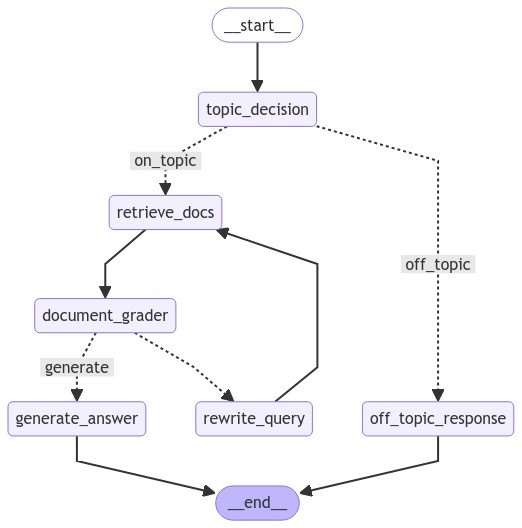

In [ ]:
# Display the workflow graph if possible.
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass


# **Testing**

# **Query 1**

In [ ]:
result = app.invoke({"question": "What are Tier I tree preservation requirements"})

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


QUESTION and GRADE: What are Tier I tree preservation requirements - Yes
RETRIEVED DOCUMENTS: [Document(metadata={'_id': '4d409573e96d40f6b360e558e108332f', '_collection_name': 'my_documents'}, page_content='Gasoline Storage Tanks* Testing Protocol.10524860486067746774677467746782678267826782679467946803735373817404740474217,8,9,1015151,72,78,80591,72,78,801,59,72,78,8028596332,57,58,62,64,65, 66,6764,7464,7470,71,72,73,74,75, 77,79,83,84,86,8775011,1528,30,31,32,33,34, 35,36,4428,30,31,32,33,34, 35,36,44376/20/20187/26/20189/3/20216/2/2022E-1573/22/2006E-1583/22/2006E-1594/5/200606DCP035X060179ZMX4a06DCP034X060180ZMX4b06DCP030K060130ZMK16dAir Quality - HVAC fuel limited to natural gasUnderground Gasoline Storage Tanks* Testing Protocol.Window Wall Attenuation & Alternate VentilationAir Quality - HVAC fuel limited to natural gasUnderground Gasoline Storage Tanks* Testing Protocol.Window Wall Attenuation & Alternate VentilationAir Quality - HVAC fuel limited to natural gasUnderground Ga

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


DOCUMENT GRADES: ['No', 'No', 'No', 'No']


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


RETRIEVED DOCUMENTS: [Document(metadata={'_id': '0bc9054992ba4e28b7b2a64bbf87035e', '_collection_name': 'my_documents'}, page_content='of #lot area#, or portion thereof, or shall equal a total of 51 percent of all #tree credits# for trees originally on site, whichever is greater.For any existing tree of at least six-inch #caliper# that is preserved, credit for one tree shall be given for the first six inches of #caliper# and, for each additional four inches of #caliper#, credit for an additional tree shall be given.Single-trunk trees, newly planted to meet this requirement, shall be of at least three-inch #caliper# at the time of planting. Multiple-trunk trees and low-branching coniferous evergreens shall be at least 10 feet in height at the time of planting. On-site trees shall be of a species selected from Appendix B (Selection List for On-site Trees).119-113 - Tier I controls during constructionLAST AMENDED12/7/1999The following requirements must be met during construction:(a) Const

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


DOCUMENT GRADES: ['Yes', 'No', 'No', 'Yes']
FILTERED DOCUMENT GRADES: ['Yes', 'Yes']


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


'For Tier I developments, the tree preservation requirements include:\n\n* Retaining existing trees and vegetation to the maximum extent possible\n* Removing or destroying trees of six-inch caliper or more only if they are located in areas to be occupied by buildings, private roads, driveways, or required accessory parking, or if they create special hazards or dangers to persons or property\n* Replacing any tree of six-inch caliper or more that cannot be preserved with alternative vegetation approved by the City Planning Commission\n* Providing on-site trees, pre-existing or newly planted, at the rate of one tree for each 1,000 square feet of lot area\n* Meeting the tree planting requirements set forth in Section 119-112, which includes providing a tree protection plan prepared by an arborist certified by the International Society of Arborculturists (ISA) or equivalent professional organization.'

In [ ]:
print(result['llm_output'])

For Tier I developments, the tree preservation requirements include:

* Retaining existing trees and vegetation to the maximum extent possible
* Removing or destroying trees of six-inch caliper or more only if they are located in areas to be occupied by buildings, private roads, driveways, or required accessory parking, or if they create special hazards or dangers to persons or property
* Replacing any tree of six-inch caliper or more that cannot be preserved with alternative vegetation approved by the City Planning Commission
* Providing on-site trees, pre-existing or newly planted, at the rate of one tree for each 1,000 square feet of lot area
* Meeting the tree planting requirements set forth in Section 119-112, which includes providing a tree protection plan prepared by an arborist certified by the International Society of Arborculturists (ISA) or equivalent professional organization.


# **Query 2**

In [ ]:
result = app.invoke({"question": 'What is SPECIAL REGULATIONS FOR LOCATION OF NEW DOORS AND WINDOWS'})

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


QUESTION and GRADE: What is SPECIAL REGULATIONS FOR LOCATION OF NEW DOORS AND WINDOWS - Yes
RETRIEVED DOCUMENTS: [Document(metadata={'_id': '59f769e857664e7fb6f88774822e0e15', '_collection_name': 'my_documents'}, page_content='Tanks* Testing Protocol.Window Wall Attenuation & Alternate VentilationUnderground Gasoline Storage Tanks* Testing Protocol.Window Wall Attenuation & Alternate VentilationWindow Wall Attenuation & Alternate Ventilation4204224224224224224284284314324324334334354351462146314631,75017311,6,9,211,5,67,9,21,31117,8,17,278,38,750181,2,3,4,5,6,8,12, 31,35,36,37,38,39, 411,2,3,4,5,6,8,12, 31,35,36,37,38,39, 4113,28,2913,28,295215,11,75015/22/20185/21/20196/17/20087/28/2020E-10611/20/2001E-10712/19/2001E-1082/27/2002E-1091/30/2002E-1101/30/200201DCP024M010689 ZMM8c01DCP078R010601 ZMR20c, 20d01DCP015Q010116 ZMQ18c01DCP065K010725 ZMK12d00DME013K020047 ZMK16aWindow Wall Attenuation & Alternate VentilationUnderground Gasoline Storage Tanks* Testing Protocol.Underground Gasoli

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


DOCUMENT GRADES: ['No', 'No', 'No', 'No']


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


RETRIEVED DOCUMENTS: [Document(metadata={'_id': 'd65899c155004d2eb2cfc2f6cab42606', '_collection_name': 'my_documents'}, page_content='Floor Use Regulations) and the following standards:(a) A storefront installed in a #building# of the #specified building type# shall occupy at least the same area of the front wall asthe original storefront. A storefront installed in any other #building# shall occupy the entire frontage of the front wall devoted to #commercial uses#.(b) Storefront entrance doors shall be set back a minimum of two feet behind the vertical surface of the #show windows#.(c) In the case of existing #buildings#, no existing cornice above a storefront shall be demolished unless required by theDepartment of Buildings. A cornice which is removed shall be replaced by a cornice having the same length, height and projection beyond the surface of the front wall. In any #building# of the #specified building type# where the original cornice above the storefront has been previously re

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


DOCUMENT GRADES: ['No', 'No', 'No', 'Yes']
FILTERED DOCUMENT GRADES: ['Yes']


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


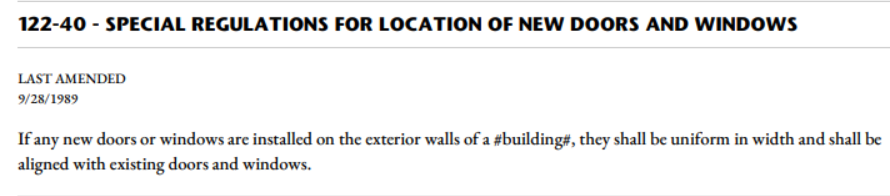

In [ ]:
print(result["llm_output"])

If any new doors or windows are installed on the exterior walls of a #building#, they shall be uniform in width and shall be aligned with existing doors and windows.


# **Query 3**

In [ ]:
result = app.invoke({"question": 'What is the Maximum Floor Area Ratio for Community Facilities'})

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


QUESTION and GRADE: What is the Maximum Floor Area Ratio for Community Facilities - Yes
RETRIEVED DOCUMENTS: [Document(metadata={'_id': '7ecd1de02d1b48d991794398c6f7deaa', '_collection_name': 'my_documents'}, page_content='5.0 and the maximum #lot coverage# shall be 70 percent on an #interior# or #through lot# and 100 percent on a #corner lot#.Where the designated district is an R9-1 District, the maximum #floor area ratio# shall be 9.0, and the maximum #lot coverage# shall be 70 percent on an #interior# or #through lot# and 100 percent on a #corner lot#.The provisions of this Section shall not apply on #waterfront blocks#, as defined in Section 62-11. In lieu thereof, the applicable maximum #floor area ratio# and #lot coverage# requirements set forth for #residential uses# in Sections 62-30 (SPECIAL BULK REGULATIONS) through 62-32 (Maximum Floor Area Ratio and Lot Coverage on Waterfront Blocks), inclusive, shall apply.However, in #Inclusionary Housing designated areas# and #Mandatory 

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


DOCUMENT GRADES: ['No', 'Yes', 'No', 'Yes']
FILTERED DOCUMENT GRADES: ['Yes', 'Yes']


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


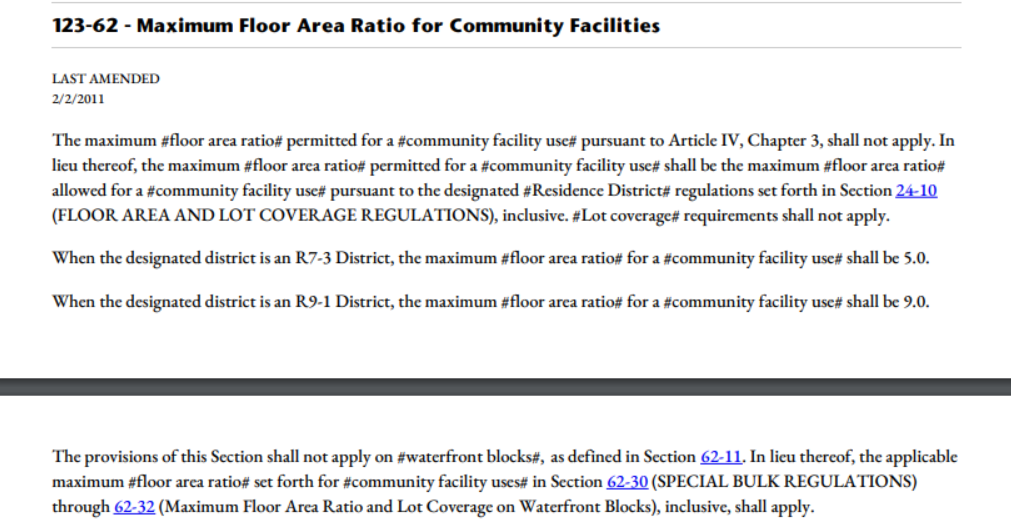

In [ ]:
print(result["llm_output"])

The maximum floor area ratio for community facilities is as follows:

* In R1-R5 districts: 1.0
* In R6-R10 districts: varies by district, but generally ranges from 2.0 to 12.0
* In R7-3 districts: 5.0
* In R9-1 districts: 9.0

Note that these values are subject to certain exceptions and special provisions, as outlined in the provided text.


# **Query 4**

In [ ]:
result = app.invoke({"question": 'What are Special Permit for Cogeneration Power Plant'})

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


QUESTION and GRADE: What are Special Permit for Cogeneration Power Plant - Yes
RETRIEVED DOCUMENTS: [Document(metadata={'_id': '7148838824694a938e4c9435db53fc56', '_collection_name': 'my_documents'}, page_content='needs of the substation, prescribe appropriate conditions and safeguards on matters necessary to effectuate the provisions of paragraph (a) of this Section that are not regulated by other applicable codes, laws, rules or regulations. The applicant shall provide the Department of City Planning with a general description of such codes, laws, rules or regulations and a certification that the proposed substation shall comply therewith.124-17 - Special Permit for Cogeneration Power PlantLAST AMENDED 2/2/2011The Board of Standards and Appeals may permit a combined heat and power cogeneration plant not to exceed 100,000 squarefeet in #floor area#, provided that:(a) the power plant is designed to maximize both electric and thermal cogeneration system efficiency to the greatest extent

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


DOCUMENT GRADES: ['Yes', 'No', 'Yes', 'No']
FILTERED DOCUMENT GRADES: ['Yes', 'Yes']


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


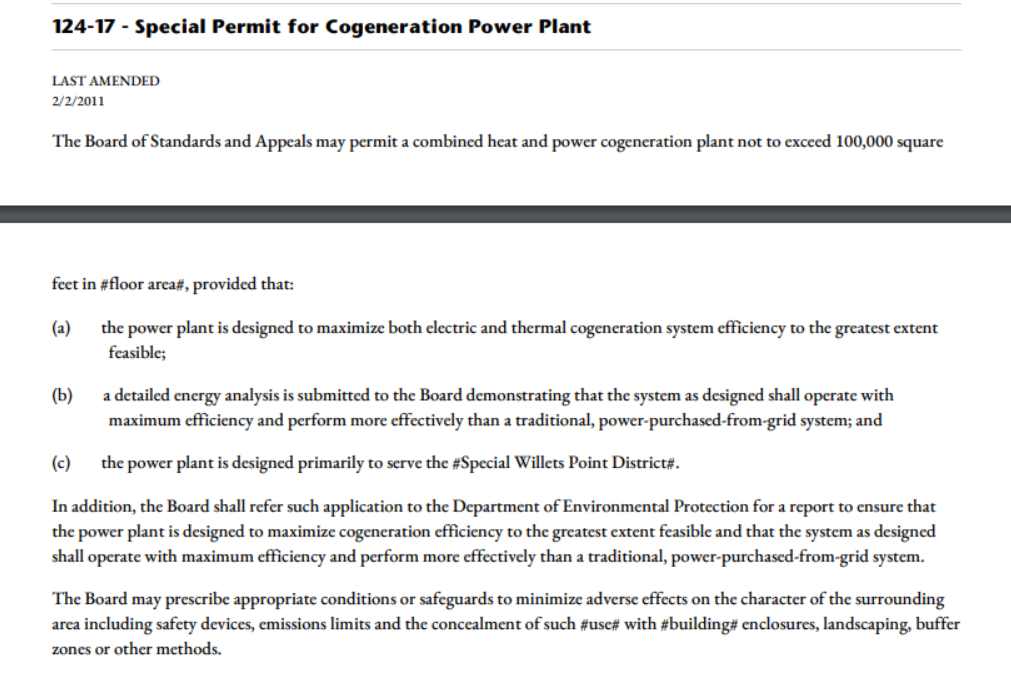

In [ ]:
print(result["llm_output"])

The Board of Standards and Appeals may permit a combined heat and power cogeneration plant not to exceed 100,000 square feet in floor area, provided that:

(a) the power plant is designed to maximize both electric and thermal cogeneration system efficiency to the greatest extent feasible;

(b) a detailed energy analysis is submitted to the Board demonstrating that the system as designed shall operate with maximum efficiency and perform more effectively than a traditional, power-purchased-from-grid system; and

(c) the power plant is designed primarily to serve the Special Willets Point District.

The Board may prescribe appropriate conditions or safeguards to minimize adverse effects on the character of the surrounding area, including safety devices, emissions limits, and the concealment of such use with building enclosures, landscaping, buffer zones, or other methods.


# **Query 5**

In [ ]:
result = app.invoke({"question": 'what are the FLUSHING WATERFRONT ACCESS PLAN with specific block and lot numbers.'})

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


QUESTION and GRADE: what are the FLUSHING WATERFRONT ACCESS PLAN with specific block and lot numbers. - Yes
RETRIEVED DOCUMENTS: [Document(metadata={'_id': '5b14cac0e7fb4f2186e9f5d5176b5834', '_collection_name': 'my_documents'}, page_content='to this Resolution pursuant to Section 200 or 201 of the City Charter and in accordance with the provisions of Sections 62-912 (Elements of a Waterfront Access Plan), 62-913 (Conditions for adoption of a Waterfront Access Plan) and this Section in order to adjust the #waterfront public access area# and #visual corridor# requirements of Sections 62-50 and 62-60, inclusive, retain the #waterfront block bulk# regulations of Section 62-30 on newly-created non-#waterfront blocks# within a specifically defined portion of the #waterfront area#, or establish #waterfront yard# requirements for #developments# otherwise exempt from the requirements of Section 62-33 (Special Yard Regulations on Waterfront Blocks).To be considered for a Waterfront Access Plan,

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


DOCUMENT GRADES: ['No', 'No', 'No', 'No']


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


RETRIEVED DOCUMENTS: [Document(metadata={'_id': 'f5a5e9665e884099a258e70d99054703', '_collection_name': 'my_documents'}, page_content='ACCESS PLAN).62-95 - Borough of QueensLAST AMENDED 4/22/2009The following Waterfront Access Plans are hereby established within the Borough of Queens. All applicable provisions of Article VI, Chapter 2, remain in effect within the areas delineated by such plans, except as expressly set forth otherwise in the plans:Q-1: Northern Hunters Point, as set forth in Section 62-951Q-2: Flushing Waterfront, in the #Special Flushing Waterfront District#, as set forth in Section 127-50 (FLUSHING WATERFRONTACCESS PLAN)Q-3: Newtown Creek, in the #Special Southern Hunters Point District#, as set forth in Section 125-46 (Newtown Creek Waterfront AccessPlan).62-951 - Waterfront Access Plan Q-1: Northern Hunters PointLAST AMENDED 2/2/2011Maps Q-1a through Q-1c in paragraph (f) of this Section show the boundaries of the area comprising the Northern Hunters Point Waterfron

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


DOCUMENT GRADES: ['No', 'No', 'Yes', 'No']
FILTERED DOCUMENT GRADES: ['Yes']


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


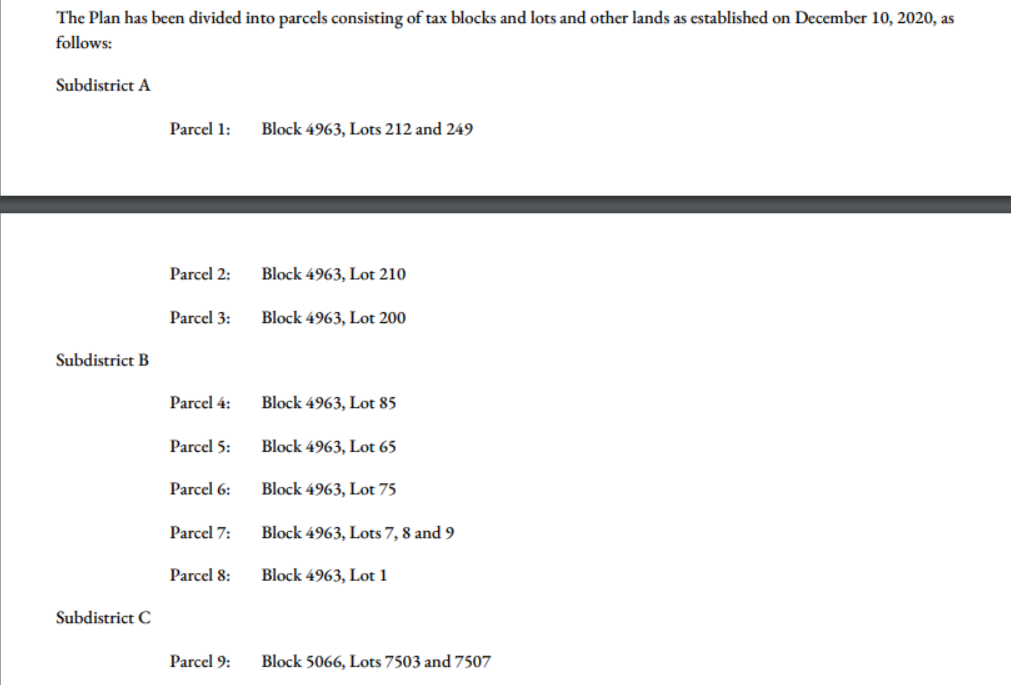

In [ ]:
print(result["llm_output"])

The Flushing Waterfront Access Plan is a part of the Special Flushing Waterfront District in Queens, New York. The plan is divided into parcels consisting of tax blocks and lots, which are listed as follows:

Subdistrict A:
Parcel 1: Block 4963, Lots 212 and 249
Parcel 2: Block 4963, Lot 210
Parcel 3: Block 4963, Lot 200

Subdistrict B:
Parcel 4: Block 4963, Lot 85
Parcel 5: Block 4963, Lot 65
Parcel 6: Block 4963, Lot 75
Parcel 7: Block 4963, Lots 7, 8, and 9
Parcel 8: Block 4963, Lot 1

Subdistrict C:
Parcel 9: Block 5066, Lots 7503 and 7507

These parcels are subject to specific requirements and regulations, including those related to visual corridors, waterfront public access areas, and special review provisions.


# **Query 6**

In [ ]:
result = app.invoke({"question": 'WHat are the Special Permit for Buildings in R7-3 Districts'})

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


QUESTION and GRADE: WHat are the Special Permit for Buildings in R7-3 Districts - Yes
RETRIEVED DOCUMENTS: [Document(metadata={'_id': 'd111a62701604ef099309a48b3d1e8b6', '_collection_name': 'my_documents'}, page_content='R6A, R6B, R7A, R7B, R7D, R7X, R8A, R8B, R8X, R9A, R9D, R9X, R10A or R10X Districts, all #buildings# containing #residences# shall comply with the #bulk# regulations for #Quality Housing buildings# set forth in Sections 23-62 (Permitted Obstructions) and 23-66. In R6, R7, R8, R9 or R10 Districts without a letter suffix, a #building# containing #residences# may be #developed# or #enlarged# pursuant to the basic height and setback requirements of Sections 23-62, 23-64 or 23-65, as applicable, or pursuant to the #bulk# regulations for #Quality Housing buildings#. All #Quality Housing buildings# shall also comply with additional provisions set forth in Article II, Chapter 8, as applicable.Special height and setback provisions are set forth in Section 23-67 (Special Height a

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


DOCUMENT GRADES: ['No', 'No', 'No', 'No']


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


RETRIEVED DOCUMENTS: [Document(metadata={'_id': '510148aec1a84ddba0d8cb348ea6e30d', '_collection_name': 'my_documents'}, page_content='changes of #use#, and any temporary parking facilities, in accordance with the approved Proposed Plans, and in a manner consistent with any additional conditions and safeguards prescribed by the Commission, shall be a condition to exercise of the special permit. Such restrictive declaration shall be recorded in the Office of the County Clerk. A copy of such declaration shall be provided to the Department of Buildings upon application for any building permit related to a #development#, #enlargement# or change of #use#.128-62 - Special Permit for Buildings in R7-3 DistrictsLAST AMENDED11/10/2021For any #zoning lot# in an R7-3 District, the City Planning Commission may permit modification of #bulk# regulations, except #floor area ratio# provisions, and modification of mandatory improvements, provided the Commission shall find that such modifications:(a) wi

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


DOCUMENT GRADES: ['Yes', 'Yes', 'No', 'No']
FILTERED DOCUMENT GRADES: ['Yes', 'Yes']


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:355: UserWarning: WARNING! stream is not default parameter.
                    stream was transferred to model_kwargs.
                    Please confirm that stream is what you intended.
  warnings.warn(


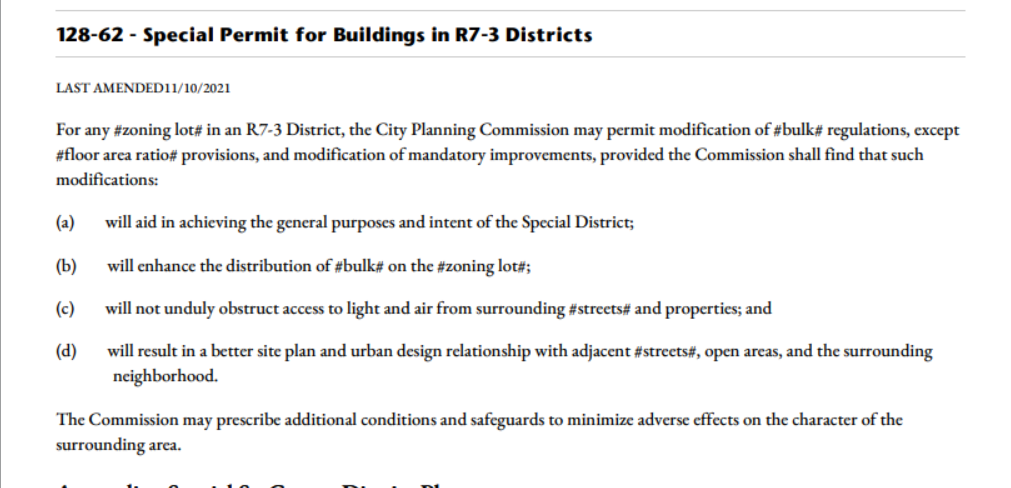

In [ ]:
print(result["llm_output"])

The special permit requirements for buildings located in R7-3 zoning districts are as follows:

* The City Planning Commission may permit modification of bulk regulations, except floor area ratio provisions, and modification of mandatory improvements.
* The Commission shall find that such modifications:
	+ Will aid in achieving the general purposes and intent of the Special District.
	+ Will enhance the distribution of bulk on the zoning lot.
	+ Will not unduly obstruct access to light and air from surrounding streets and properties.
	+ Will result in a better site plan and urban design relationship with adjacent streets, open areas, and the surrounding neighborhood.
* The Commission may prescribe additional conditions and safeguards to minimize adverse effects on the character of the surrounding area.
